# Ch. 6. Algorithm Analysis 

## I. Intro to Parallel Algorithm Analysis
This course assumes you have done some computer science, but does not assume any knowledge of algorithm design or formal algorithm analysis. However, I still want to do some basic analysis of some parallel algorithms and serial algorithms, so you have some understanding of what kinds of things will make your code faster, and what kind of code can even be made faster. We're going to be very informal about our algorithm analysis because it's more fun that way, and we will still get a few important points across. After this chapter, I want you to have some intuition that helps you understand why this graph looks the way it does:
![parallel time graph](https://ars.els-cdn.com/content/image/1-s2.0-S0098300413001465-gr9.jpg)
So, let's get started. We talked, as far back as Ch. 3, about what a parallel algorithm looks like and what makes an algorithm parallel. We talked about trivially parallelizable algorithms and monte carlo simulations. What we didn't talk about, specifically, is how these different algorithms change how workflows run. Essentially, if something is trivially parallelizable, if you go from 1 core to _n_ cores, without changing any parameters, you should see a roughly _n_ times speedup. This means that the run time of this program should be roughly $\frac{1}{n}\times (original\ running\ time)$. This means, as you add more cores to your trivially parallelizable code, you should see your code's runtime shrink as $\frac{1}{n}$. This graph is what that looks like:
![1/n](https://i.imgur.com/MbqqIAn.png)

This graph assumes that your code initally took 10 seconds to run, and by the time you add five cores, you already only take ten seconds to run your code.

### Example 6.1 - Monte Carlo Analysis
Given what we just talked about, Monte Carlo simulations should fit nicely into that class of algorithms. We should see a linear speedup and a resulting runtime proportional to $\frac{1}{n}$. In this example, we're going to investigate that and try to show with empirical data that this holds for this case. This should hopefully complement our theoretical analysis from earlier and help convince you that this makes sense. We're going to use our parallel monte carlo pi from earlier, and time it as we scale it.

In [1]:
# Defining parallel monte carlo pi calculation 

import random
import multiprocessing
from multiprocessing import Pool


#caculate the number of points in the unit circle
#out of n points
def monte_carlo_pi_part(n):
    
    count = 0
    for i in range(n):
        x=random.random()
        y=random.random()
        
        # if it is within the unit circle
        if x*x + y*y <= 1:
            count=count+1
        
    #return
    return count  

In [2]:
import time
# Note that this cell takes a while to run

n = 1000000

times = []
# Call the process with different sized pools
for np in range(1,32, 2):
    start = time.time()
    part_count=[n//np for i in range(np)]
    pool = Pool(processes=np)   
    # parallel map
    count=pool.map(monte_carlo_pi_part, part_count)
    pi = sum(count)/(n*1.0)*4
    end = time.time()
    tot = end - start
    times.append(tot)
    print("Esitmated value of Pi: {} ({} cores, time: {}s)".format(pi, np, tot))

Esitmated value of Pi: 3.143792 (1 cores, time: 0.3256404399871826s)
Esitmated value of Pi: 3.138968 (3 cores, time: 0.20728302001953125s)
Esitmated value of Pi: 3.141076 (5 cores, time: 0.16989612579345703s)
Esitmated value of Pi: 3.140996 (7 cores, time: 0.19002652168273926s)
Esitmated value of Pi: 3.138292 (9 cores, time: 0.2144463062286377s)
Esitmated value of Pi: 3.143748 (11 cores, time: 0.2107558250427246s)
Esitmated value of Pi: 3.139948 (13 cores, time: 0.333815336227417s)
Esitmated value of Pi: 3.142084 (15 cores, time: 0.380648136138916s)
Esitmated value of Pi: 3.14266 (17 cores, time: 0.3281419277191162s)
Esitmated value of Pi: 3.13832 (19 cores, time: 0.35321569442749023s)
Esitmated value of Pi: 3.144188 (21 cores, time: 0.44190454483032227s)
Esitmated value of Pi: 3.141788 (23 cores, time: 0.34867143630981445s)
Esitmated value of Pi: 3.14272 (25 cores, time: 0.3506624698638916s)
Esitmated value of Pi: 3.142452 (27 cores, time: 0.3757209777832031s)
Esitmated value of Pi: 3

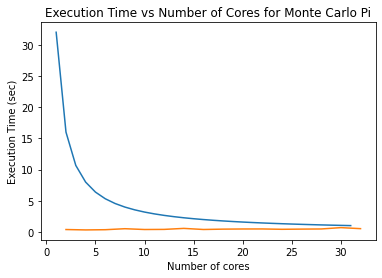

In [6]:
%matplotlib inline
# Plot the times we collected
import matplotlib.pyplot as plt
import numpy as np

#h Helper function to plot an equation
def graph(formula, x_range):  
    x = np.array(x_range)  
    y = formula(x) 
    plt.plot(x, y)  

# Graph theoretical maximum (in blue)
graph(lambda x: 32/x, range(1, 32))

# Graph empirical data (in orange)
plt.plot([i*2 for i in range(1,17)], times)

plt.ylabel("Execution Time (sec)")
plt.xlabel("Number of cores")
plt.title("Execution Time vs Number of Cores for Monte Carlo Pi")
plt.show()
# Hopefully, this looks a little like a nice 1/x curve. If not, something is probably broken

## II. Strictly Serial Algorithms
We've seen how algorithms that respond very well to scale do, now what about the other end of the spectrum? If there are algorithms that can be parallelized really easily, it seems like there _should_ be some that can not. Why? Well, it just feels like it! While that's not really valid logic, the assumption is correct. There's a family of algorithms that can simply not be parallelized. This family is called _strictly serial algorithms_, and they are more common than you might think. One such common example is the Fibonacci sequence. The Fibonacci sequence is defined recursively, such that the _n_-th number in the sequence is the sum of the _n-1_-th and the _n-2_-th. That is to say that _fib(n)_ = _fib(n-1)+fib(n-2)_. Because of this, dependence on the previous values, computing the _n_-th Fibonacci number is a strictly serial task. (This is not actually true, as the Fibonacci sequence does indeed have a closed form solution, but that's not the point of this exercise. There are sequences which only have recursive forms, but they're more complicated). This image shows how Fibonacci number computations are always recursively broken down into calls of `fib(1)` or `fib(o)`:
![fib call tree](https://i.stack.imgur.com/7iU1j.png)

### Example 6.2 - Fibonacci Sequence Generator
Because we mentioned how the Fibonacci sequence is a strictly serial algorithm, we're now going to use it as an example. We will write a recursive Fibonacci sequence generator and perform some analysis.

In [1]:
# Compute Nth fibonacci number
def fib(n):
    if n==0 or n==1:
        return 1
    return fib(n-1) + fib(n-2)

In [2]:
import time
# Feel free to play around with this
times = []
for i in range(0, 40, 2):
    before = time.time()
    res = fib(i)
    after = time.time()
    tot = after-before
    print("fib({}) = {} ({}sec)".format(i, res, tot))
    times.append(tot)

fib(0) = 1 (2.1457672119140625e-06sec)
fib(2) = 2 (4.0531158447265625e-06sec)
fib(4) = 5 (2.86102294921875e-06sec)
fib(6) = 13 (5.245208740234375e-06sec)
fib(8) = 34 (1.33514404296875e-05sec)
fib(10) = 89 (3.2901763916015625e-05sec)
fib(12) = 233 (9.298324584960938e-05sec)
fib(14) = 610 (0.00018453598022460938sec)
fib(16) = 1597 (0.0004634857177734375sec)
fib(18) = 4181 (0.0014042854309082031sec)
fib(20) = 10946 (0.026520967483520508sec)
fib(22) = 28657 (0.02066183090209961sec)
fib(24) = 75025 (0.04781007766723633sec)
fib(26) = 196418 (0.04711270332336426sec)
fib(28) = 514229 (0.2011420726776123sec)
fib(30) = 1346269 (0.32071733474731445sec)
fib(32) = 3524578 (0.926093339920044sec)
fib(34) = 9227465 (2.2386114597320557sec)
fib(36) = 24157817 (5.4180614948272705sec)
fib(38) = 63245986 (14.035428762435913sec)


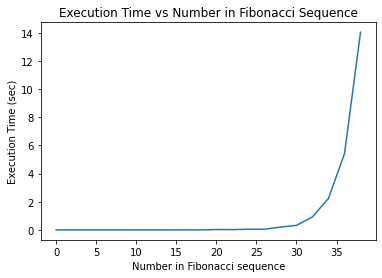

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plot the times we collected

plt.plot([2*i for i in range(20)], times)
plt.ylabel("Execution Time (sec)")
plt.xlabel("Number in Fibonacci sequence")
plt.title("Execution Time vs Number in Fibonacci Sequence")
plt.show()

Hopefully, you can see that attempting to parallelize any computation like this is hopeless. 

Let's examine the call tree for calculating the fifth fibonacci number:
```
fib(5) -> fib(4)+fib(3)
            |      |
      fib(3)+fib(2)|
                fib(2)+fib(1)
and so on
```

Now, the execution will still be sequential. This is because, even if you could fork a thread for each call in the tree, it would spawn so many new threads that it simply wouldn't be worth it to do that. It would slow the program down so much that it would end up slower than the serial algorithm you started with.  

In general, you want to parallelize only "embarrassingly parallel" tasks. That is, tasks which are computationally expensive and can be computed independently. Many people forget about the first part. Threads are so expensive that it only makes sense to make one when you have a huge amount of work for them to do, and moreover, that you can devote an entire processor to the thread. If you have 8 processors then making 80 threads is going to force them to share the processor, slowing each one of them down tremendously. You'd do better to make only 8 threads and let each have 100% access to the processor when you have an embarrassingly parallel task to perform.

In this case, it is theoretically possible to parallelize the algorithm (slightly), but practically not worth it. In some cases, such as non primitive recursive problems (like [the Ackermann function](https://en.wikipedia.org/wiki/Ackermann_function)), it's completely impossible. 

Also, note that this could be sped up by a lot through the use of [dynamic programming](https://en.wikipedia.org/wiki/Dynamic_programming), but that's not what this course is about.

## III. Task Parallelism vs. Data Parallelism
As you may gather from the title of this section, there are two flavors of parallelism which are important: task parallelism and data parallelism. Do you remember when we talked about Single Instruction, Multiple Data (SIMD)? Well, if you did (or if you didn't), you might be able to guess that SIMD is an example of data parallelism. Let's define data parallelism better. 

Data parallelism focuses on distributing the data across different nodes, which operate on the data in parallel. It can be applied on regular data structures like arrays and matrices by working on each element in parallel. It contrasts to task parallelism as another form of parallelism, where tasks are distributed rather than data (we'll get to this in a moment). 

As this definition suggests, data parallelism occurs when the same thing needs to happen to many different pieces of input data. This is a nice thing to have happen, because it is generally easy to make happen in parallel. Data parallelism is something you should look for when you're trying to speed up your code. It is easy to parallelize, and many different types of problems can be reduced to them.

This image represents a data-parallel process:
![data parallel job](https://upload.wikimedia.org/wikipedia/commons/a/a7/Sequential_vs._Data_Parallel_job_execution.png)
The top describes a job happening in serial, while the bottom shows how one would divide up the top job into the four jobs represented on the bottom, but producing identical output.

Now, let's get into task parallelism. What is task parallelism? Well, task parallelism is a form of parallelism where data is not distributed, but instructions are. Using our acronyms from before, it would be Multiple Instruction, Single Data (MISD). Task parallelism focuses on distributing tasks across different processors. In contrast to data parallelism which involves running the same task on different components of data, task parallelism is distinguished by running many different tasks at the same time on the same data.

In a multiprocessor system, task parallelism is achieved when each processor executes a different thread (or process) on the same or different data. The threads may execute the same or different code. In the general case, different execution threads communicate with one another as they work, but is not a requirement. Communication usually takes place by passing data from one thread to the next as part of a workflow.

As a simple example, if a system is running code on a 2-processor system (CPUs "a" & "b") in a parallel environment and we wish to do tasks "A" and "B", it is possible to tell CPU "a" to do task "A" and CPU "b" to do task "B" simultaneously, thereby reducing the run time of the execution.

The image below represents a comparison between task and data parallelism, with task parallelism on the left and data parallelism is on the right.

![parallelism comparison](http://lh3.googleusercontent.com/8hC1WoryRSmlqL7iQ3VtQwRnCLeO2Wa5zejBw3pmUlXxLpoqhRC2OhNPLZTPfz5OlD4tdmt7V6YqXqBqYmSgg_CQakRHs6IGbwtaliLuUqj7pM6_gCcSbZKSnwoUXaVZnZ8s2pWz4nVxTDnovHjjTxCdpu7p6jly4-Z7ddBH5G43k7ffP8Y-3tXL-o-4UJ-7LJj62Oh7oHEOybzfuw1_MfbDN6N_utlGwuWh1rvy97Niu9Oy9EUS4E7t4N6aJkYUlZptNY7bxC8i0MixcXnCxkH0PtRv7_P-eubpTl2VyKFBEqPyOTsq_8rpiSLsD0vVNjMB7erjSihoNpTI24891t-TOgkJIb2ShZjzUVeyJQQqT2f7tkLCGYRfr8E2V60evnzFw5jyvr06tmImsAvtL2jvo7mduggeusz7HGu6KpUL1APfqt9hFqeJIZOYxUWc-lk7tJ_-XVvhiU4ouwDsKJB2ZhSt_leZODmmE76JtFBSnikFv4ip4YHlt3TwVcsjYF5QNTDHV_rX7CupI2ODOV9gV7MHE6bEkd06edUP7kclqojT1H4C1OUS_yHqHu-3aEpOkuzF-65KGLZ9gRIQL-hyLAGcKJw=w300-h225-no)

### Example 6.3 - Basic Task and Data Parallelism
In this example, we will design one workflow that exhibits task parallelism and one that exhibits data parallelism. A nice real world example of something that is not only a nice simple example of a parallel algorithm, but is also an example of a real world computational task that comes up a lot is matrix multiplication. This image displays how data parallelism comes up in the problem of matrix multiplication:
![matrix multiplication data parallelism](https://upload.wikimedia.org/wikipedia/commons/6/68/Data_Parallelism_in_matrix_multiplication.png)
You can see that after some basic serial computation to set up the right hand side of the equation, each one of the cells in the 3x2 matrix on the right hand side can be computed concurrently or in parallel. This represents data parallelism because the same multiplication and addition instructions are used on different data. For multiplication, we can divide matrix A and B into blocks along rows and columns respectively. This allows us to calculate every element in matrix C individually thereby making the task parallel. 

For example: $A(m \times n) \cdot B (n \times k)$ can be finished in $O(n)$ time instead of $O(m*n*k)$, when executed in parallel using $m*k$ processors. (This is the example from the image).

As our example of task parallelism, we are going to use a very simple workflow - computing the square root of many numbers in parallel and computing the square of many numbers concurrently. This way, we have a single instruction (sqrt) which is run on some data, and a second instruction (square) which is run on other data. Based on the fact that all of the input data is in one data pool, a list, this is task parallelism because we are applying different tasks to data in different parts of the same data pool.

In [7]:
# Data parallel matrix multiplication
import random
import multiprocessing
from itertools import starmap, repeat
from operator import mul

def calc_row_of_product_matrix(a_row, b, izip=zip):
    '''Calculate a row of the product matrix P = A * B
    Arguments:
      a_row is af A
      b is the B matrix
    returns the corresponding row of P matrix'''
    return map(lambda col: sum(starmap(mul,zip(a_row,col))), zip(*b))

def eval_func_tuple(f_args):
    '''Takes a tuple of a function and args, evaluates and returns result'''
    return f_args[0](*f_args[1:])

class multimatrix(list):

    def __mul__(self, b, izip=zip, repeat=repeat):
        '''Concurrent matrix multiplication with multiprocessing.Pool. '''
        pool = multiprocessing.Pool(multiprocessing.cpu_count())
        return pool.map(eval_func_tuple, izip(repeat(calc_row_of_product_matrix), self, repeat(b))) 

class itermatrix(list):

    @staticmethod
    def sumprod(row, col, sum=sum, starmap=starmap, mul=mul):
        '''Returns sumproduct of two vectors.'''
        return sum(starmap(mul,zip(row,col)))

    def __mul__(self, b, imap=map, izip=zip):
        '''Matrix multiplication returning iterable of iterables'''
        return map(lambda row: map(lambda col: itermatrix.sumprod(row, col), zip(*b)), self)

def iterate_results(result):
    '''Iterate over iterable of iterables,
    and returns elements in list of lists.
    Usage: if you want to run the whole calculation at once:
    p = iterate_results(itermatrix([[1, 3], [-5, 6], [2, 4]]) * itermatrix([[1, 4], [8, 7]]))'''
    return[[col for col in row] for row in result]

def random_v(K=1000,min=-1000,max=1000):
    '''Generates a random vector of dimension N;
    Returns a list of integers.
    The values are integers in the range [min,max].'''
    return [random.randint(min,max) for k in range(K)]

def random_m(N=1000, K=1000):
    '''Generates random matrix. Returns list of list of integers.'''
    return [random_v(K) for n in range(N)]

In [8]:
%%time

if __name__ == '__main__':
    a = [[1, 3], [-5, 6], [2, 4]]
    b = [[1, 4], [8, 7]]
    adotb = [[25, 25], [43, 22], [34, 36]]
    #A = multimatrix(a)
    #B = multimatrix(b)
    #prod = A * B
    #assert(adotb == prod)
    #print(prod, "multi test OK")
    A = itermatrix(a)
    B = itermatrix(b)
    iterprod = A * B
    listprod = iterate_results(iterprod)
    assert(adotb == listprod)
    print(listprod, "iter test OK")

[[25, 25], [43, 22], [34, 36]] iter test OK
CPU times: user 1.42 ms, sys: 174 µs, total: 1.6 ms
Wall time: 1.06 ms


In [9]:
%%time
# Task parallel suqare roots and squares
import multiprocessing

# I know there's a library function for this
# I want it to be a bit slower so we can see the
# performance benefits of the parallelism
def sqrt(n):
    return n**(0.5)

def square(n):
    return n**2

run_serial = False # switch to True if you want to see it run slowly...
if run_serial:
    sqrts = []
    squares = []
    for i in range(1000000):
        if i%2 == 0:
            sqrts.append(sqrt(i))
        else:
            squares.append(square(i))
    print(sqrts[0:9])
    print(squares[0:9])
                           

pool = multiprocessing.Pool(32)
sqrts = pool.map(sqrt, [i for i in range(1000000) if i%2==0])
squares = pool.map(square, [i for i in range(1000000) if i%2==1])
print(sqrts[0:9])
print(squares[0:9])

[0.0, 1.4142135623730951, 2.0, 2.449489742783178, 2.8284271247461903, 3.1622776601683795, 3.4641016151377544, 3.7416573867739413, 4.0]
[1, 9, 25, 49, 81, 121, 169, 225, 289]
CPU times: user 616 ms, sys: 1.4 s, total: 2.02 s
Wall time: 2.51 s


## IV. Maximum Speedups
By now, you should understand that different types of algorithms can be helped by parallelization different amounts. Let's go ahead and quantify that. First, let's do some mathematical analysis and figure out how well we could do. The first major breakthrough in terms of parallel algorithm analysis is called [Amdahl's Law](https://en.wikipedia.org/wiki/Amdahl%27s_law). Formulated by Gene Amdahl in 1967, Amdahl's Law allows us to compute theoretical maximum speedups based on how parallelizable our tasks are. In order to figure out your theoretical maximum, you need to know how many processors you have access to and what percentage of your program can be parallelized. For example, if a program needs 20 hours using a single processor core, and a particular part of the program which takes one hour to execute cannot be parallelized, while the remaining 19 hours (p = 0.95, where p is the fraction of the code that can be parallelized) of execution time can be parallelized, then regardless of how many processors are devoted to a parallelized execution of this program, the minimum execution time cannot be less than that critical one hour. Hence, the theoretical speedup is limited to at most 20 times (1/(1 − p) = 20). For this reason, parallel computing with many processors is useful only for highly parallelizable programs. This image sums up Amdahl's law for various values of p.
![amdahl's law](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/AmdahlsLaw.svg/640px-AmdahlsLaw.svg.png)

Another parallel algorithm analysis law, the [Gustafson–Barsis Law](https://en.wikipedia.org/wiki/Gustafson%27s_law), gives the theoretical speedup in latency of the execution of a task at fixed execution time that can be expected of a system whose resources are improved. This law considers not how much faster your code can get, but instead how much more you can do with the same code in the same amount of time as you scale up your computer. Amdahl's law presupposes that the computing requirements will stay the same, given increased processing power. In other words, an analysis of the same data will take less time given more computing power.

Gustafson, on the other hand, argues that more computing power will cause the data to be more carefully and fully analyzed: pixel by pixel or unit by unit, rather than on a larger scale. Where it would not have been possible or practical to simulate the impact of nuclear detonation on every building, car, and their contents (including furniture, structure strength, etc.) because such a calculation would have taken more time than was available to provide an answer, the increase in computing power will prompt researchers to add more data to more fully simulate more variables, giving a more accurate result.


Amdahl's Law reveals a limitation in, for example, the ability of multiple cores to reduce the time it takes for a computer to boot to its operating system and be ready for use. Assuming the boot process was mostly parallel, quadrupling computing power on a system that took one minute to load might reduce the boot time to just over fifteen seconds. But greater and greater parallelization would eventually fail to make bootup go any faster, if any part of the boot process were inherently sequential.

Gustafson's law argues that a fourfold increase in computing power would instead lead to a similar increase in expectations of what the system will be capable of. If the one-minute load time is acceptable to most users, then that is a starting point from which to increase the features and functions of the system. The time taken to boot to the operating system will be the same, i.e. one minute, but the new system would include more graphical or user-friendly features.

This image sums up Gustafson's law for various values of p (same p as earlier):
![Theoretical maximum speedup](https://cdn.comsol.com/wordpress/2014/03/Graph-depicting-how-the-size-of-the-job-increases-with-the-number-of-available-processes.png)


### Example 6.4 - Timing Fibonacci and Monte Carlo
Given all of that theory we just learned, what do you think the value of _p_ is for the Monte Carlo pi simulation? For the Fibonacci sequence generator? Think about it for a moment. Read ahead when you've got a guess. For the Monte Carlo Pi, the value of _p_ is very close to 1, while for the Fibonacci sequence generator, the value of _p_ is very close to 0. Hopefully the description and examples of those tasks make those values believable to you. In case they don't, we're going to time them right now, in this example. 

In [10]:
# Defining parallel monte carlo pi calculation 

import random
import multiprocessing
from multiprocessing import Pool


#caculate the number of points in the unit circle
#out of n points
def monte_carlo_pi_part(n):
    
    count = 0
    for i in range(n):
        x=random.random()
        y=random.random()
        
        # if it is within the unit circle
        if x*x + y*y <= 1:
            count=count+1
        
    #return
    return count  

In [13]:
%%time

# Calling parallel monte carlo pi simulation

# Nummber of points to use for the Pi estimation
n = 10000000
np = multiprocessing.cpu_count()
# iterable with a list of points to generate in each worker
# each worker process gets n/np number of points to calculate Pi from

part_count=[n//np for i in range(np)]

#Create the worker pool
# http://docs.python.org/library/multiprocessing.html#module-multiprocessing.pool
pool = Pool(processes=np)   

# parallel map
count=pool.map(monte_carlo_pi_part, part_count)

print("Esitmated value of Pi: {} ".format(sum(count)/(n*1.0)*4))

Esitmated value of Pi: 3.141528 
CPU times: user 13.9 ms, sys: 30.8 ms, total: 44.8 ms
Wall time: 3.14 s


In [14]:
%%time
import multiprocessing
import time

# Fibonacci sequence on 32 cores

# Compute Nth fibonacci number
def fib(n):
    if n==0 or n==1:
        return 1
    return fib(n-1) + fib(n-2)

def calc_single_fib(i):
    before = time.time()
    res = fib(i)
    after = time.time()
    tot = after-before

pool = multiprocessing.Pool(32)
tasks = pool.map(calc_single_fib, range(0, 40, 2))

CPU times: user 134 ms, sys: 517 ms, total: 651 ms
Wall time: 24.4 s


Note that even though we run each distinct fibonacci number in parallel, we can't parallelize the underlying function at all, so it's still very slow.

## Exercise 6. Pi Over Many Nodes or Fibonacci Over Many Nodes
Using Parsl, implement a fibonacci sequence generator and a mote carlo pi simulation. Run it on the entire cluster. Which one runs faster? Which one seems to scale better?

In [ ]:
# Your code goes here